<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/IFNFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns
sns.set()
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe
  # ricordarsi di abilitare lo sharing pubblico dei dati

  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

# df =  panda_from_gspreadsheet('1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg', sheet_name='Sheet1')
df =  panda_from_gspreadsheet('1bPAhcjzy2BQFaGO2-I3_XsZSpZ0060jcwqIyuPkxR2w', sheet_name='Sheet1')

def Exp(x, p0, p1): # negative exponential
  import numpy as np
  return p0*np.exp(x/p1)

def Line(x, m, q):
  import numpy as np
  return m*x + q

def Gain(x, p0, p1):
  import numpy as np
  return p0*x**p1

In [2]:
df

,Timestamp,Email Address,Experiment or project/initiative,Unnamed: 3,Computing model evolution,Real Data amount,Real Data size,Data structure,Metadata/calibrations/slow-control,Production sites,...,CPU - total amount (III),CPU - total amount (II),Storage - size (III),Storage - size (II),Tape - size (III),Tape - size (II),Score,Additional comments/specifications,Storage - size,Storage - size.1
0,4/12/2023 17:09:52,bruno.giacomazzo@unimib.it,TEONGRAV,NaN,Currently defined and stable,No Real Data,No Real Data,NaN,Other,CINECA,...,10-100,NaN,100TB-1PB,NaN,<1TB,NaN,NaN,We are a collaboration of theoretical research...,NaN,NaN
1,4/12/2023 19:11:31,francesco.sanfilippo@infn.it,LQCD123,NaN,Currently defined and stable,No Real Data,No Real Data,"Simulation, analyis",Metadata,Simulations at HPC facilities,...,100-1000,60-90%,100TB-1PB,30-60%,100TB-1PB,30-60%,NaN,NaN,NaN,NaN
2,4/14/2023 9:30:44,claudio.gatti@lnf.infn.it,QubIT e progetti PNRR collegati,NaN,Currently defined and in evolution in the next...,100k-1M,10-100kB,Raw - Histograms,"Metadata, Calibration data, Slow-control info",LNF,...,<10,NaN,1-100TB,NaN,<1TB,0%,NaN,Necessita' CPU RAM e disco principalmente per ...,NaN,NaN
3,4/14/2023 11:23:20,alberto.andrighetto@lnl.infn.it,ISOLPHARM project,NaN,Currently defined and in evolution in the next...,No Real Data,No Real Data,MC,Other,Cloud Veneto,...,10-100,10-30%,<1TB,1-10%,<1TB,0%,NaN,no,NaN,NaN
4,4/14/2023 12:58:14,spighi@bo.infn.it,FOOT,NaN,Currently defined and stable,1-100M,10-100kB,raw + reco (same for real and MC),Calibration data,produced in different beam facilities and tran...,...,10-100,>90%,100TB-1PB,>90%,<1TB,0%,NaN,no,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,5/23/2023 18:30:17,defilippo@ct.infn.it,CHIRONE,NaN,Currently defined and in evolution in the next...,1-100M,10-100kB,3 : raw data (also wave signals) + root uncali...,"Metadata, Calibration data, Slow-control info",INFN-LNS (main production site),...,10-100,1-10%,1-100TB,10-30%,100TB-1PB,10-30%,NaN,NaN,NaN,NaN
65,5/23/2023 19:50:29,massimi@bo.infn.it,n_TOF,NaN,Being defined within 2-5 years,No Real Data,10-100kB,raw,NaN,claud @ cnaf,...,<10,0%,<1TB,0%,NaN,0%,NaN,NaN,NaN,NaN
66,5/25/2023 12:37:33,Andrea.Bressan@ts.infn.it,EIC_NET,NaN,Being defined in <2 years,>100M,1MB-10MB,"Raw, mDST, Filtered, uDST","Metadata, Calibration data, Slow-control info","BNL, JLab, ANL, CNAF, FR-CCIN2P3 e altri siti ...",...,100-1000,>90%,100TB-1PB,>90%,>10PB,0%,NaN,-,NaN,NaN
67,5/25/2023 14:30:57,contalbrigo@fe.infn.it,JLab12,NaN,Currently defined and in evolution within the ...,>100M,10-100kB,4: raw - decoded - dst (high level information...,"Metadata, Slow-control info",Real data: JLab e NERSC; Simulation on OSG and...,...,>1000,30-60%,1-100TB,10-30%,<1TB,NaN,NaN,NaN,NaN,NaN


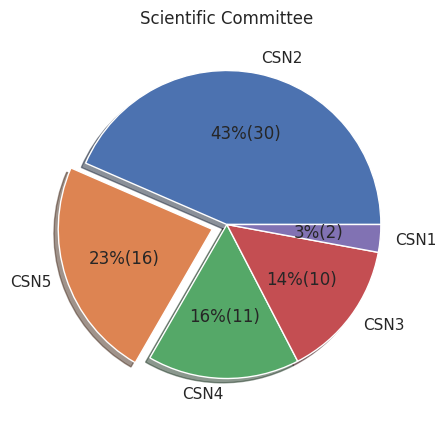

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1, 0, 0, 0]
what = "Scientific Committee"
elements = len(df[what])
pd.value_counts(df[what]).plot(kind='pie', autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="",
                                     shadow=True, explode=explode)
plt.title(what)
plt.show()

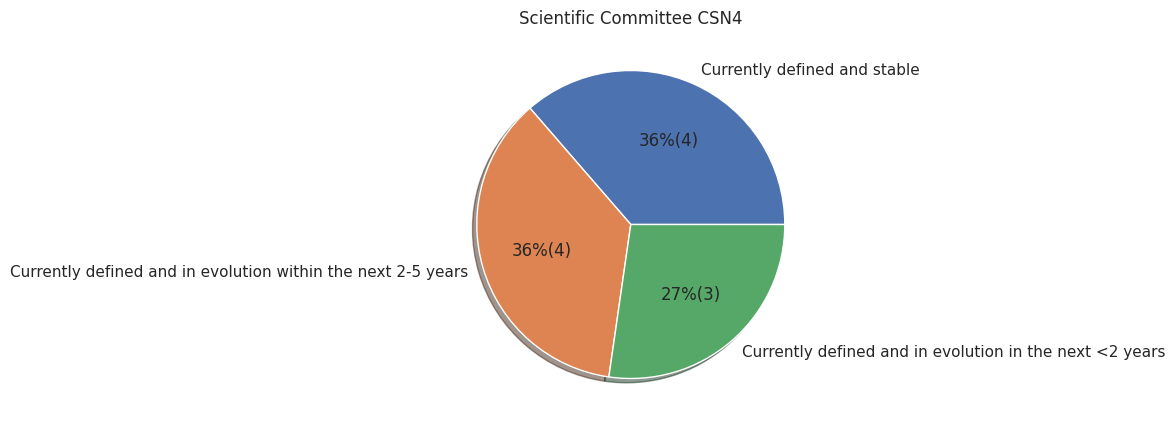

-------------------------------------------------------------------------------------------------------------------------------------------------


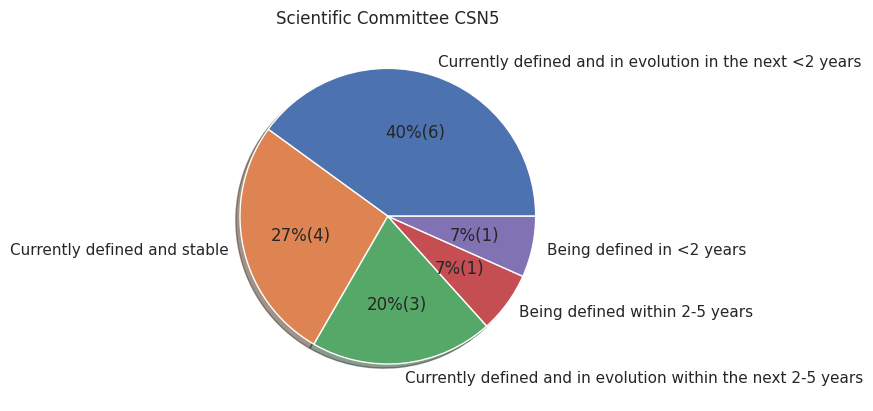

-------------------------------------------------------------------------------------------------------------------------------------------------


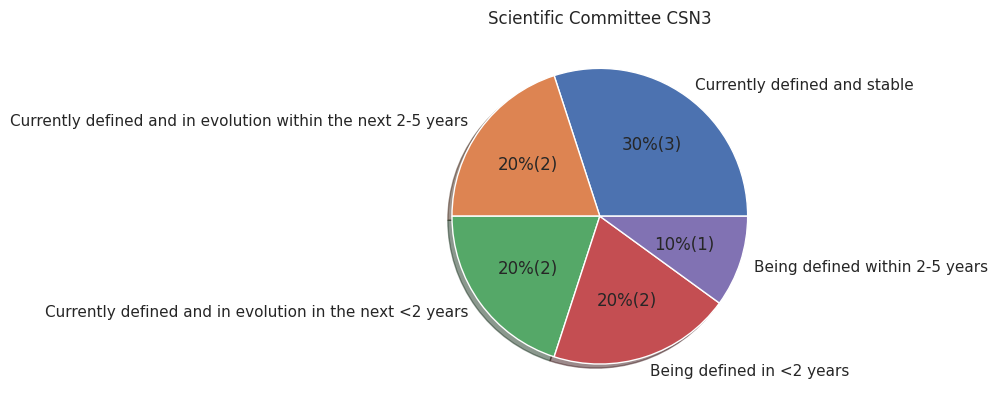

-------------------------------------------------------------------------------------------------------------------------------------------------


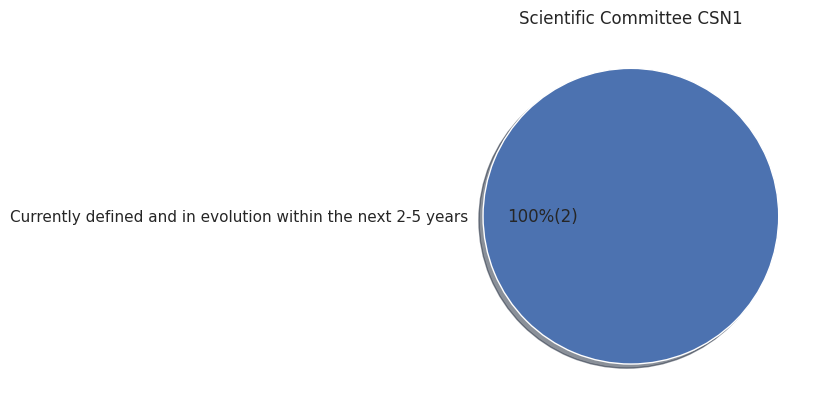

-------------------------------------------------------------------------------------------------------------------------------------------------


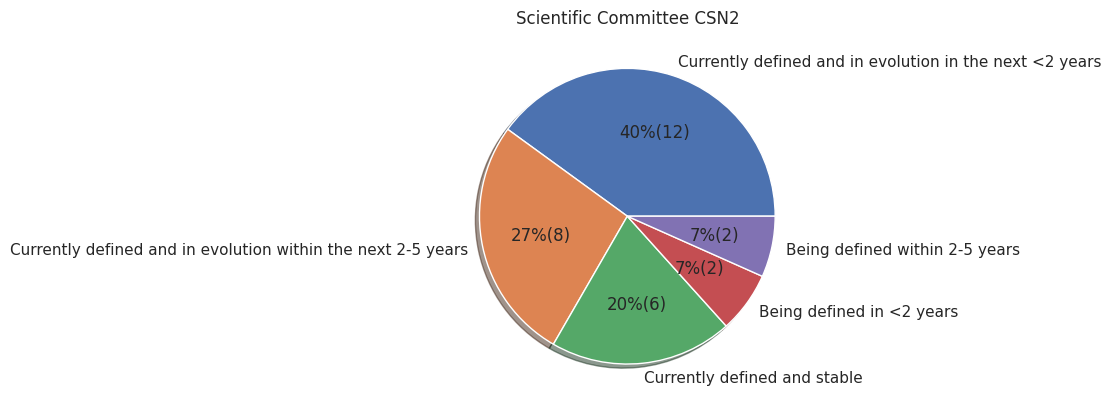

-------------------------------------------------------------------------------------------------------------------------------------------------


In [4]:
fig, ax = plt.subplots(figsize=(5,5))
colors = ["g", "w", "k", "y", "c"]
#explode = [0, 0.1, 0, 0, 0]
#data = df[(df["Scientific Committee"]=="CSN4") & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["Storage - size (I)"]
what = "Scientific Committee"
CSN = pd.unique(df[what])
for i, csn in enumerate(CSN):
  data = df[(df[what]==csn)]["Computing model evolution"]
  elements = len(data)
  pd.value_counts(data).plot(kind='pie', autopct=lambda x: '{:.0f}%({:.0f})'.format(x, x*elements/100), label="", shadow=True)
  plt.title(what+" "+csn)
  plt.show()
  print("-------------------------------------------------------------------------------------------------------------------------------------------------")

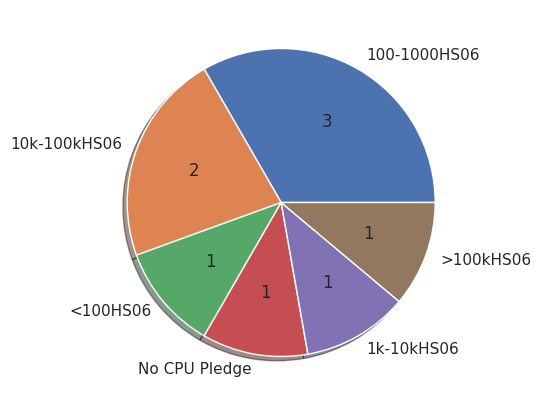

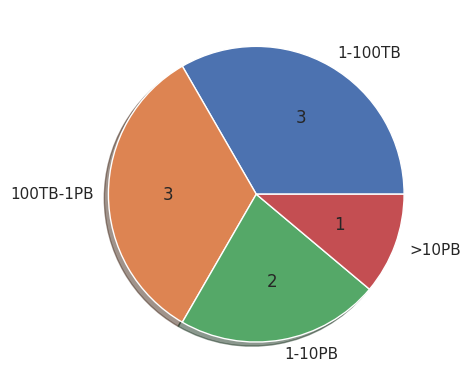

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
colors = ["g", "w", "k", "y", "c"]
#explode = [0, 0.1, 0, 0, 0]
#data = df[(df["Scientific Committee"]=="CSN4") & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["CPU - total amount (I)"]
#data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["Storage - size (I)"]
#data = df[df["Computing model evolution"]=="Currently defined and stable"]["CPU - total amount (I)"]
elements = len(data)
pd.value_counts(data).plot(kind='pie', autopct=lambda x: '{:.0f}'.format(x*elements/100), label="",
                                     shadow=True)#, explode=explode)
plt.show()
data = df[((df["Scientific Committee"]=="CSN1") | (df["Scientific Committee"]=="CSN2") | (df["Scientific Committee"]=="CSN3")) & (df["Computing model evolution"]=="Currently defined and stable")]["Storage - size (I)"]
#data = df[df["Computing model evolution"]=="Currently defined and stable"]["CPU - total amount (I)"]
elements = len(data)
df.value_counts(data).plot(kind='pie', autopct=lambda x: '{:.0f}'.format(x*elements/100), label="",
                                     shadow=True)#, explode=explode)
plt.show()

In [17]:
df.columns

Index(['Timestamp', 'Email Address', 'Experiment or project/initiative',
       'Unnamed: 3', 'Computing model evolution', 'Real Data amount',
       'Real Data size', 'Data structure',
       'Metadata/calibrations/slow-control', 'Production sites', 'Workflow',
       'Data access', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount (I)', 'CPU - HPC (I)', 'CPU - HTC',
       'CPU - interactive', 'CPU - batch system (I)', 'CPU - web based tools',
       'CPU - personal VMs', 'CPU - graphic access', 'CPU - services (I)',
       'CPU - temporary overpledge (I)', 'CPU - special environment (I)',
       'CPU - R&D', 'Storage - size (I)', 'Storage - experiment data (I)',
       'Storage - user data (I)', 'Storage - secondary data (I)',
       'Storage - executables and libraries', 'Storage - read-only',
       'Storage - POSIX', 'Storage - access (I)', 'Tape - size (I)',
       'Tape - access frequency (I)', 'Tape - inventory',
       'Tape - replicas and backups

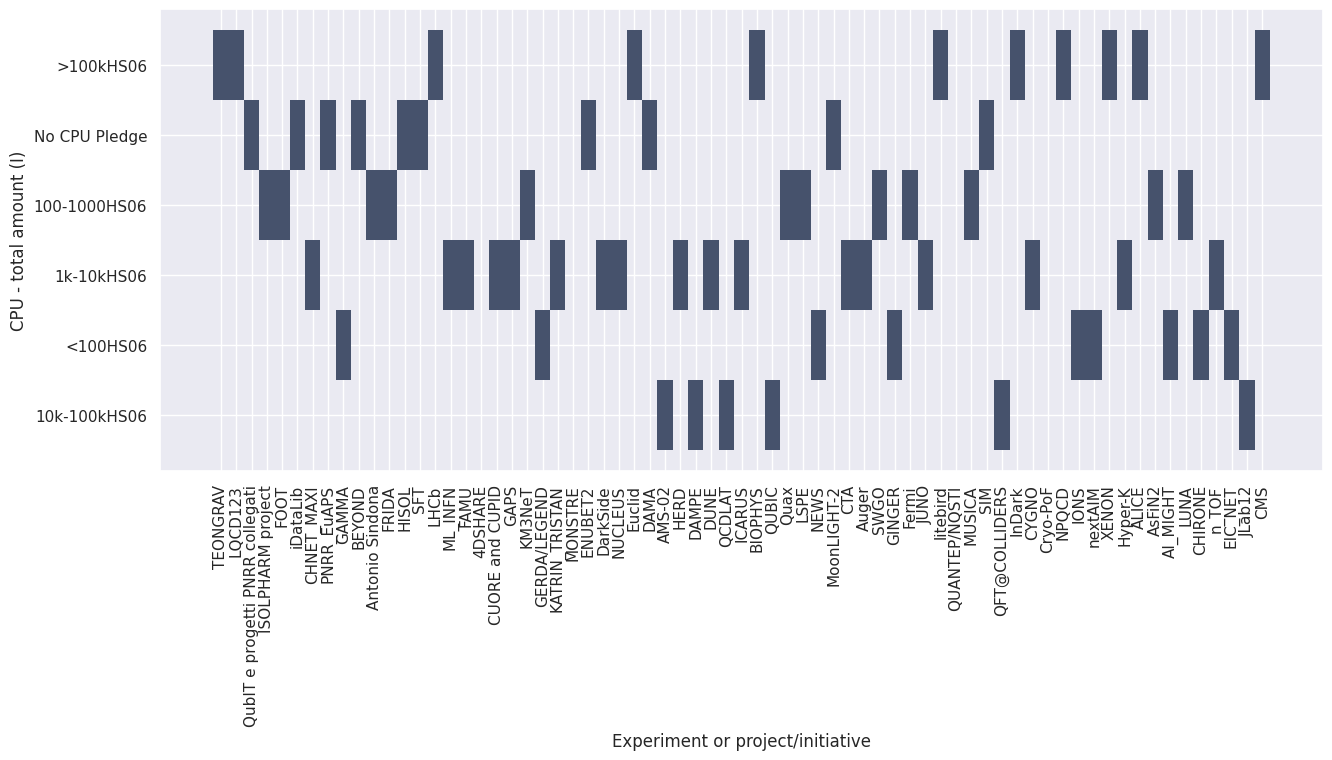

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(df, x="Experiment or project/initiative", y="CPU - total amount (I)")
ax.tick_params(axis='x', rotation=90)
plt.show()

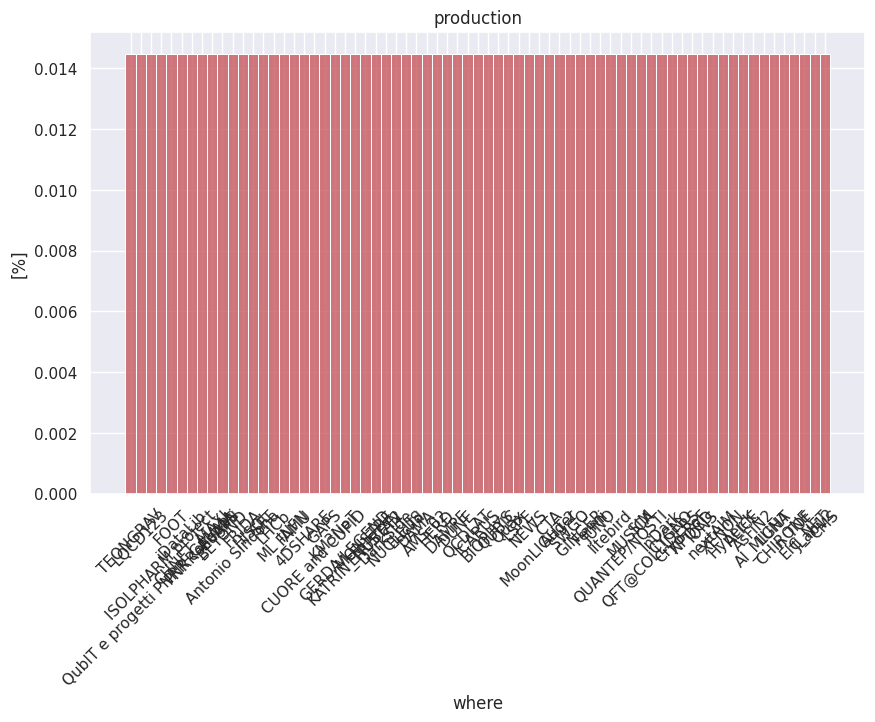

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="Experiment or project/initiative", stat='probability', bins=13, color='r')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production")
#plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])
plt.show()

TypeError: ignored

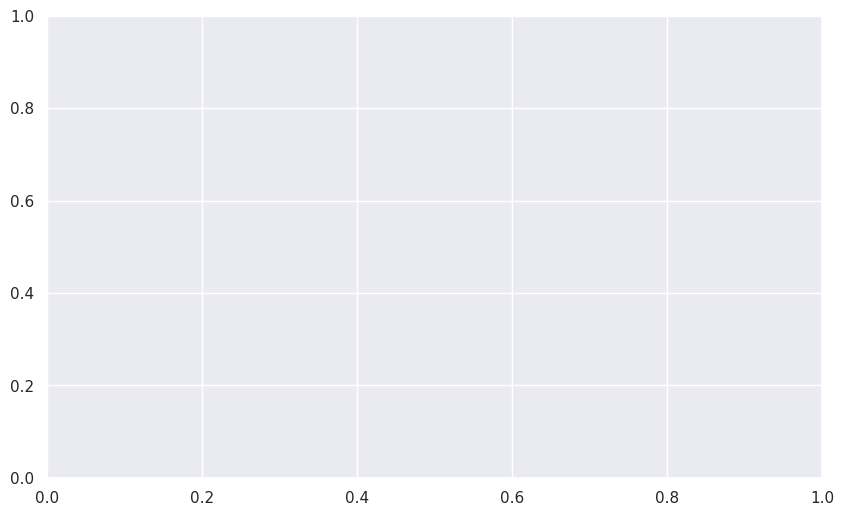

In [7]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment or project/initiative", y="CPU - total amount (I)")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

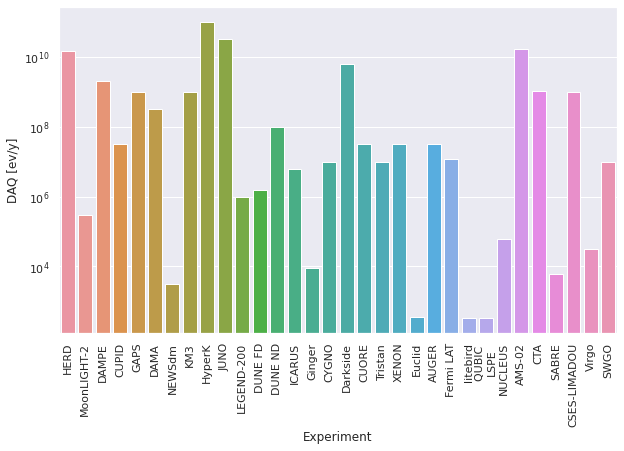

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="DAQ rate events/y")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

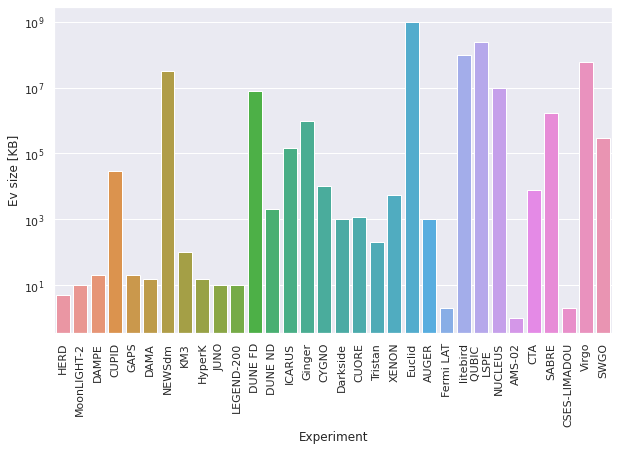

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="size KB")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("Ev size [KB]")
plt.show()

In [ ]:
df[['Email Address', 'Experiment']]

,Email Address,Experiment
0,mori@fi.infn.it,HERD
1,luca.porcelli@lnf.infn.it,MoonLIGHT-2
2,margherita.disanto@gssi.it,DAMPE
3,giovanni.benato@lngs.infn.it,CUPID
4,alessio.tiberio@fi.infn.it,GAPS
5,pierluigi.belli@roma2.infn.it,DAMA
6,valeri@na.infn.it,NEWSdm
7,cbozza@unisa.it,KM3
8,kryss@sa.infn.it,HyperK
9,stefanomaria.mari@uniroma3.it,JUNO


In [ ]:
df.columns

Index(['Timestamp', 'Email Address', 'Experiment', 'DAQ type',
       'Data organization', 'DAQ rate events/y', 'Data amount', 'size KB',
       'Data size', 'Data structure', 'Metadata/calibrations/slow-control',
       'Production sites', 'where', 'where stored', 'Workflow', 'Data access',
       'public', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount', 'CPU (100HS06=10core)', 'RAM (GB)', 'CPU - HPC',
       'HPC', 'CPU - HTC', 'HTC', 'CPU - interactive', 'interactive',
       'CPU - batch system', 'batch', 'CPU - web based tools', 'web tool',
       'CPU - personal VMs', 'personal VMs', 'CPU - graphic access',
       'graphic access', 'CPU - services', 'services',
       'CPU - temporary overpledge', 'temporary overpledge',
       'CPU - special environment', 'special environment', 'CPU - R&D', 'R&D',
       'Storage - size', 'TB', 'file size GB', 'Storage - experiment data',
       'experiment data', 'Storage - user data', 'Storage - secondary data'

damp all db

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
from IPython.display import display
for i, field in enumerate(df.columns):
  if i> 2:
    # print(field)
    # data = df[['Experiment', field]].values
    #display(df[['Experiment', field]])
    display(data_table.DataTable(df[['Experiment', field]], include_index=False, num_rows_per_page=32))


**prudctio site**: Where data are produced, stored, etc...? From where are distributed? (include also metadata/calibrations/slow-control)

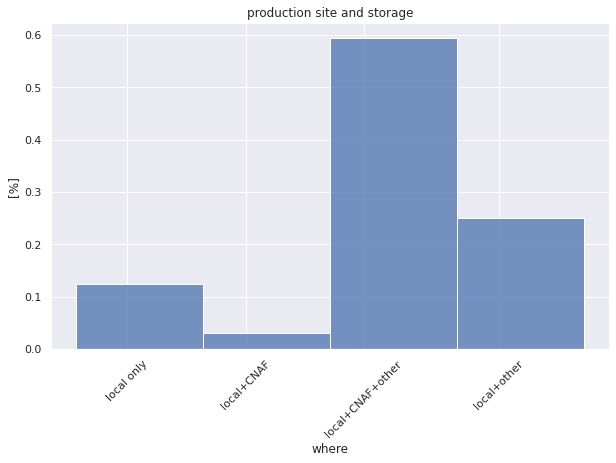

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="where stored", stat='probability', bins=4)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production site and storage")
plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])

plt.show()

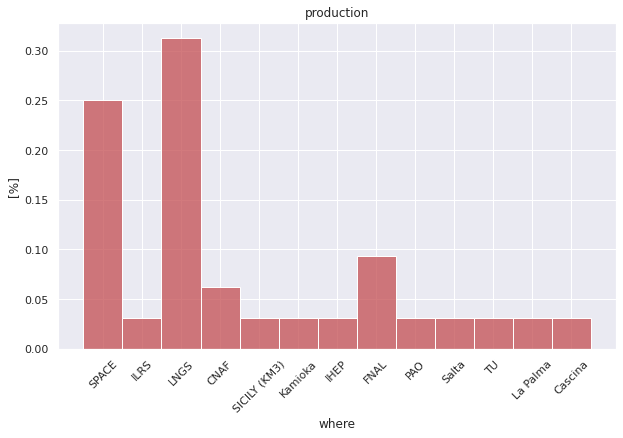

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=df, x="Experiment", y="where stored")
sns.histplot(data=df, x="where", stat='probability', bins=13, color='r')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production")
#plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])
plt.show()

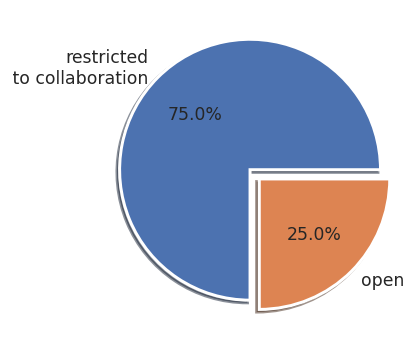

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
#colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1]
labels = ["restricted\n to collaboration", "open"]
elements = len(df["public"])
ax.pie(x=df.value_counts(df["public"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.show()

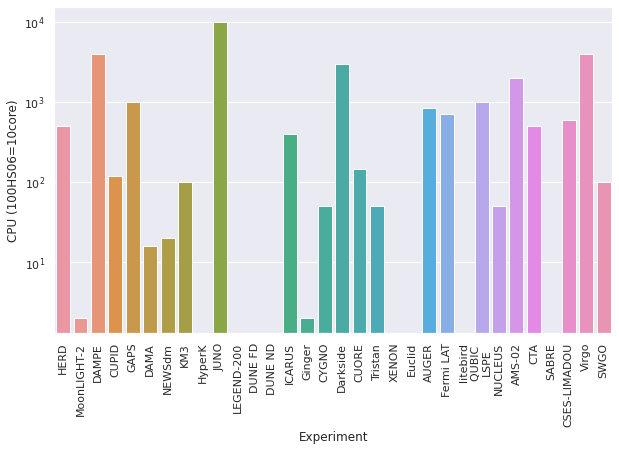

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="CPU (100HS06=10core)")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_ylabel("Ev size [KB]")
plt.show()

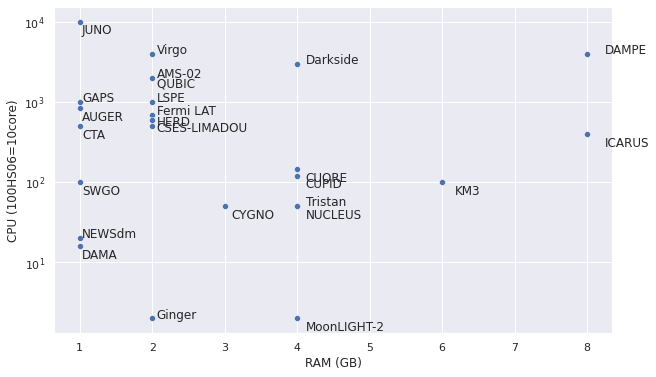

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
what="CPU (100HS06=10core)"
sns.scatterplot(data=df[df[what]>0], x="RAM (GB)", y=what)
for i in range(df.shape[0]):
  if df[what][i]>0:
    x=df["RAM (GB)"][i]+df["RAM (GB)"][i]*0.03
    y=df[what][i]-df[what][i]*(i%2)*0.3
    plt.text(x=x, y=y, s=df["Experiment"][i])
#ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylabel("Ev size [KB]")
#ax.set_ylim(0,5000)
plt.show()

In [ ]:
df[df["CPU (100HS06=10core)"]>0]["CPU (100HS06=10core)"].sum()*10

291925.0

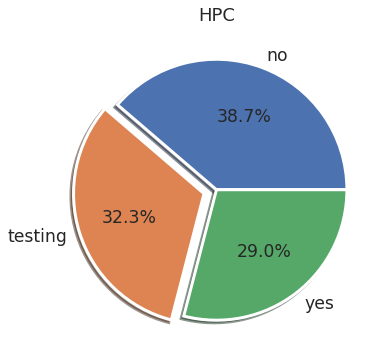

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
colors = ["g", "w", "k"]
explode = [0, 0.1, 0]
labels = ["no", "testing", "yes"]
elements = len(df["HPC"])
ax.pie(x=df.value_counts(df["HPC"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
ax.set_title('HPC', fontsize=18)
plt.show()

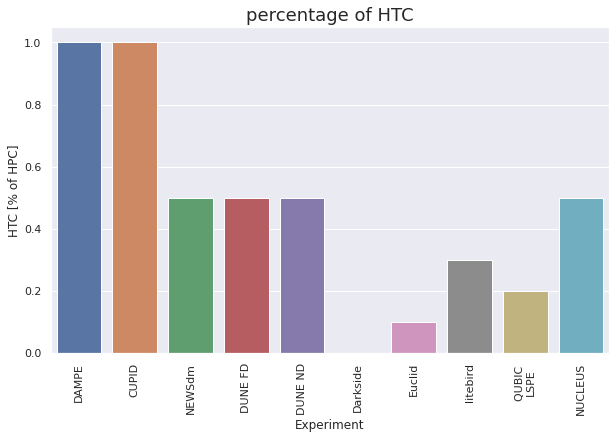

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df[df["HPC"]>1], x="Experiment", y="HTC")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("HTC [% of HPC]")
ax.set_title('percentage of HTC', fontsize=18)
plt.show()

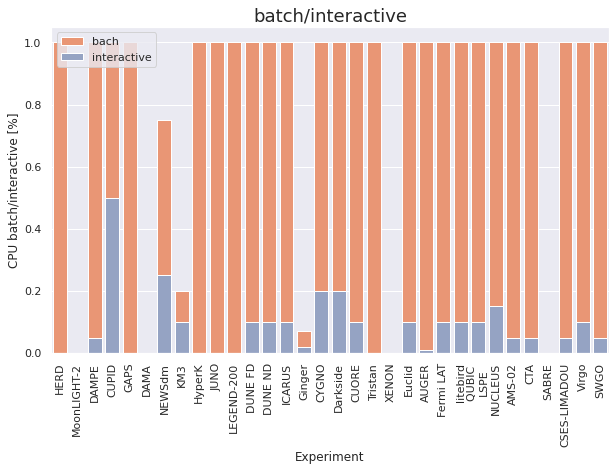

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df['total'] = df.interactive+df.batch
sns.barplot(data=df, x="Experiment", y="total", color=sns.color_palette("Set2", 10)[1], label="bach")
sns.barplot(data=df, x="Experiment", y="interactive", color=sns.color_palette("Set2", 10)[2], label="interactive")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("CPU batch/interactive [%]")
ax.set_title('batch/interactive', fontsize=18)
plt.legend()
plt.show()

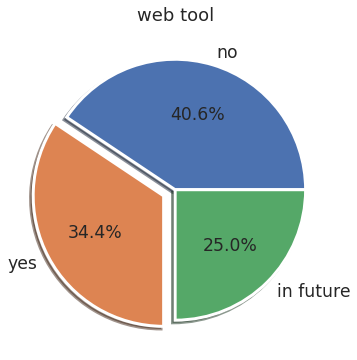

In [ ]:
def maybe_pie(dbframe,what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1, 0]
  labels = ["no", "yes", "in future"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
def yesno_pie(dbframe, what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1]
  labels = ["no", "yes"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
maybe_pie(df,"web tool")

In [ ]:
df.columns

Index(['Timestamp', 'Email Address', 'Experiment', 'DAQ type',
       'Data organization', 'DAQ rate events/y', 'Data amount', 'size KB',
       'Data size', 'Data structure', 'Metadata/calibrations/slow-control',
       'Production sites', 'where', 'where stored', 'Workflow', 'Data access',
       'public', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount', 'CPU (100HS06=10core)', 'RAM (GB)', 'CPU - HPC',
       'HPC', 'CPU - HTC', 'HTC', 'CPU - interactive', 'interactive',
       'CPU - batch system', 'batch', 'CPU - web based tools', 'web tool',
       'CPU - personal VMs', 'personal VMs', 'CPU - graphic access',
       'graphic access', 'CPU - services', 'services',
       'CPU - temporary overpledge', 'temporary overpledge',
       'CPU - special environment', 'special environment', 'CPU - R&D', 'R&D',
       'Storage - size', 'TB', 'file size GB', 'Storage - experiment data',
       'experiment data', 'Storage - user data', 'Storage - secondary data'

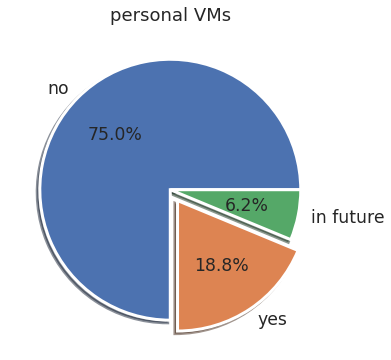

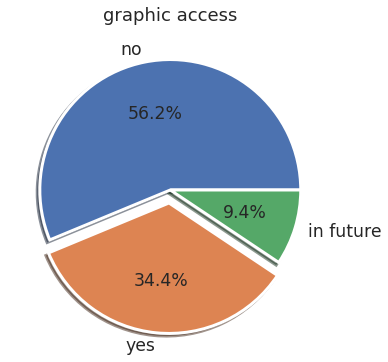

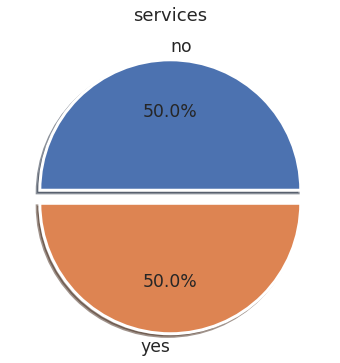

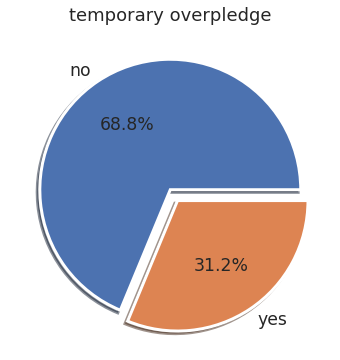

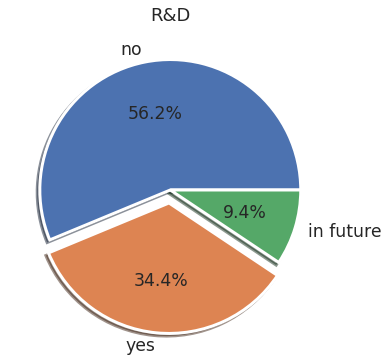

In [ ]:
maybe_pie(df,"personal VMs")
maybe_pie(df,"graphic access")
yesno_pie(df,"services")
yesno_pie(df,"temporary overpledge")
#maybe_pie("special environment")
maybe_pie(df,"R&D")



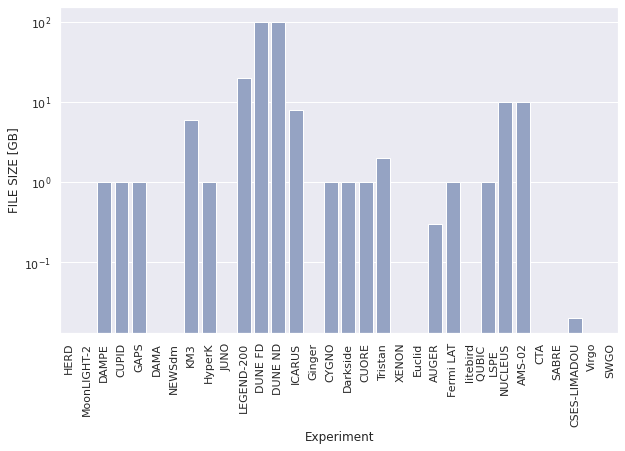

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="file size GB", color=sns.color_palette("Set2", 10)[2])
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("FILE SIZE [GB]")
plt.show()

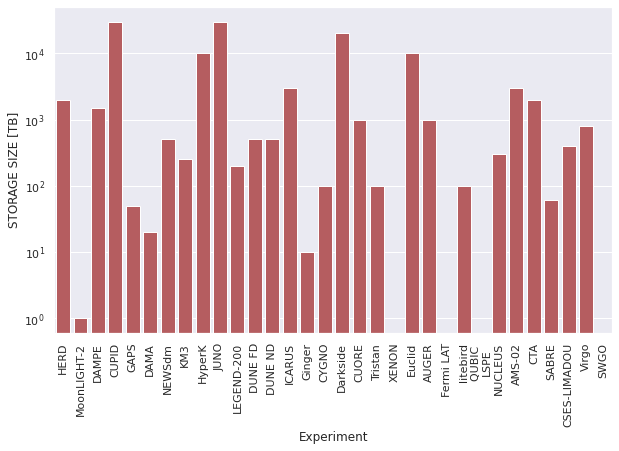

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="TB", color='r')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("STORAGE SIZE [TB]")
plt.show()

In [ ]:
df[df.TB>0].TB.sum()/1000


117.391

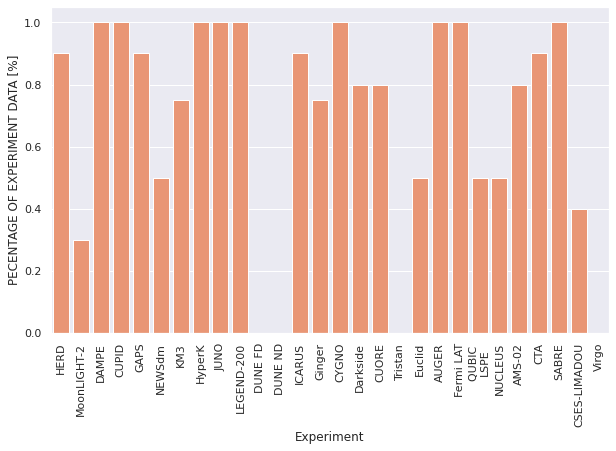

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df[df["experiment data"]>=0], x="Experiment", y="experiment data", color=sns.color_palette("Set2", 10)[1])
ax.tick_params(axis='x', rotation=90)
# ax.set_yscale('log')
ax.set_ylabel("PECENTAGE OF EXPERIMENT DATA [%]")
plt.show()

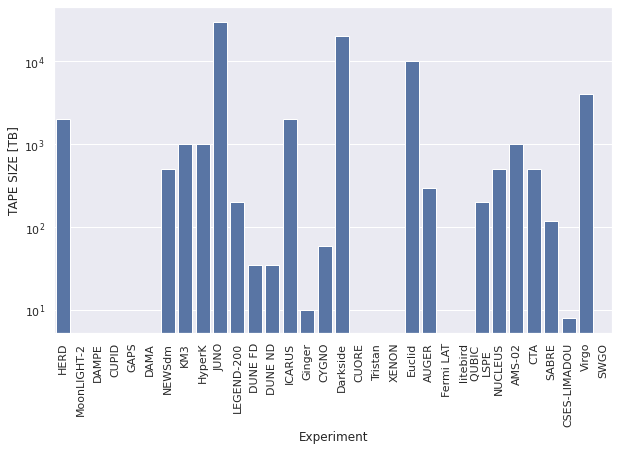

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x="Experiment", y="tape size", color='b')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("TAPE SIZE [TB]")
plt.show()

In [ ]:
df[df["tape size"]>0]["tape size"].sum()/1000

73.468